In [1]:
import numpy as np
import pandas as pd
import time 
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder

E:\Anaconda2\envs\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import seaborn as sns
%matplotlib inline
p = sns.color_palette()
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

#https://github.com/mwaskom/seaborn/issues/1009

**读入数据:**

In [159]:
dataset.shape

(69495, 326)

# 用户信息表：  
69495 rows × 303 columns

In [178]:
train = pd.read_csv("../feature/训练表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/测试表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
test=test.fillna(-1)

dataset= pd.concat([train,test],axis=0).reset_index()
label=dataset[['用户标识','标签']]
dataset=dataset.drop(['index','用户标识'],axis=1)

dataset=pd.get_dummies(dataset,columns=dataset[['用户性别','用户职业','用户教育程度','用户婚姻状态','用户户口类型']]).drop(['标签'],axis=1)
dataset #69495 rows × 24 columns
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True)
dataset=poly.fit_transform(dataset)
df = pd.DataFrame(dataset.reshape(69495,301))
df.interpolate(axis=1).values.reshape(dataset.shape)

#dataset
#trains=pd.merge(label,df,left_index=True,right_index=True,how='outer')
trains=pd.concat([label,df],axis=1)
print(trains.shape)#69495 rows × 303 columns

(69495, 303)


# 用户浏览行为训练表：  
69495 rows × 343 columns

In [179]:
train = pd.read_csv("../feature/用户浏览行为测试表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户浏览行为训练表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
dataset= pd.concat([train,test],axis=0)

temp=dataset[:]
temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户浏览行为缺失统计']=(dataset==-1).sum(axis=1)
#用均值填充缺失值
#temp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)
trains=pd.merge(trains,temp,how='left', on = "用户标识")
print(trains.shape)

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(69495, 39)
(69495, 40)
(69495, 342)


# 用户银行流水记录表：  
69495 rows × 369  columns

In [180]:
train = pd.read_csv("../feature/用户银行流水记录训练表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户银行流水记录测试表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
dataset= pd.concat([train,test],axis=0)
temp=dataset[:]
temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户银行流水记录缺失统计']=(dataset==-1).sum(axis=1)
#用均值填充缺失值
#temp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)
trains=pd.merge(trains,temp,how='left', on = "用户标识")
print(trains.shape)

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(69495, 25)
(69495, 26)
(69495, 367)


# 用户账单表初级特征:  
69495 rows × 448  columns

In [181]:
beifen=trains
train = pd.read_csv("../feature/用户账单表初级特征训练表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户账单表初级特征测试表_20170119_A.csv",encoding="gb2312") # 注意自己数据路径
dataset= pd.concat([train,test],axis=0)
temp=dataset[:]
temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户账单表初级特征缺失统计']=(dataset==-1).sum(axis=1)
#特征轮：构造放款后与放款前差值特征
feature_name=temp.columns 
for name in feature_name:
    if name.find('款后')> 0:
        x1=name.replace('款后','款前')
        if x1 in feature_name:
            temp[name+"与"+x1+"差值"]=temp[name]-temp[x1]        
#用均值填充缺失值
#emp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)
trains=pd.merge(trains,temp,how='left', on = "用户标识")
print(trains.shape)#69495 rows × 445  columns

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(69495, 56)
(69495, 79)
(69495, 445)


# 用户账单表特征:  
69495 rows × 1146 columns


In [182]:
beifen=trains[:]
train = pd.read_csv("../feature/用户账单表特征训练表20170203_时间已知.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户账单表特征测试表20170203_时间已知.csv",encoding="gb2312") # 注意自己数据路径
dataset= pd.concat([train,test],axis=0)
temp=dataset[:]
temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)#(69495, 473)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户账单表特征_时间已知缺失统计']=(dataset==-1).sum(axis=1)
#特征轮：构造放款后与放款前差值特征
feature_name=temp.columns 

for name in feature_name:
    if name.find('款后')> 0:
        x1=name.replace('款后','款前')
        if x1 in feature_name:
            temp[name+"与"+x1+"差值"]=temp[name]-temp[x1]        
#用均值填充缺失值
#temp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)#(69495, 706)
trains=pd.merge(trains,temp,how='left', on = "用户标识")
print(trains.shape)#69495 rows × 1150 columns

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(69495, 473)
(69495, 706)
(69495, 1150)


# 用户账单表特征训练表20170203_时间未知

In [183]:
beifen=trains[:]
train = pd.read_csv("../feature/用户账单表特征训练表20170203_时间未知.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户账单表特征测试表20170203_时间未知.csv",encoding="gb2312") # 注意自己数据路径

#2017.02.04随机删除部分时间未知样本，保证训练集与测试集的特征分布相似
print(train.shape)
train已知=train[train['时间未知上期账单金额sum'].isnull().values==True]#(39830, 241)
print(train已知.shape)
train未知=train[train['时间未知上期账单金额sum'].isnull().values==False]#(15766, 241)
print(train未知.shape)
t1,t2=train_test_split(train未知, test_size = 0.5,random_state=36)#
print(t1.shape)
train=pd.concat([train已知,t1],axis=0)
print(train.shape)

####################################################################

dataset= pd.concat([train,test],axis=0)
#dataset['账单时间未知标志']=1
temp=dataset[:]
#temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)#(69495, 242)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户账单表特征_时间未知缺失统计']=(dataset==-1).sum(axis=1)        
#用均值填充缺失值
#temp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)#(69495, 243)
trains=pd.merge(trains,temp,how='inner', on = "用户标识")#1154+243
print(trains.shape)#(69495, 1392)

(55596, 241)
(39830, 241)
(15766, 241)
(7883, 241)
(47713, 241)
(61612, 241)
(61612, 242)
(69495, 1391)


In [197]:
train未知.to_csv("../feature/账单时间未知特征_20170204.csv",index=None,encoding="gb2312") 

# 用户账单表特征训练表20170203_整体

In [110]:
beifen=trains[:]
train = pd.read_csv("../feature/用户账单表特征训练表20170203_整体.csv",encoding="gb2312") # 注意自己数据路径
test = pd.read_csv("../feature/用户账单表特征测试表20170203_整体.csv",encoding="gb2312") # 注意自己数据路径
dataset= pd.concat([train,test],axis=0)
temp=dataset[:]
#temp.drop('放款时间',axis=1, inplace=True)
print(temp.shape)#(69495, 242)
#统计行和列的缺失值数
dataset=dataset.fillna(-1)
temp['用户账单表特征_时间未知缺失统计']=(dataset==-1).sum(axis=1)        
#用均值填充缺失值
#temp.fillna(temp.mean(),inplace=True)
temp.fillna(0,inplace=True)
print(temp.shape)#(69495, 243)
trains=pd.merge(trains,temp,how='left', on = "用户标识")#1154+243
print(trains.shape)#(69495, 1633)

(69495, 241)
(69495, 242)
(69495, 608)


In [186]:
#trains.to_csv("../feature/特征汇总_20170119_A.csv",index=None,encoding="gb2312") #mean填充 69495 rows × 1171 columns 没有删去用户标识
#trains.to_csv("../feature/特征汇总_20170119_B.csv",index=None,encoding="gb2312") #0填充  69495 rows × 1171 columns 没有删去用户标识

#trains.to_csv("../feature/特征汇总_20170119_D.csv",index=None,encoding="gb2312") #0填充 69495 rows × 1146 columns 当前最高分0.43267
#trains.to_csv("../feature/特征汇总_20170119_E.csv",index=None,encoding="gb2312") #mean填充 69495 rows × 1146 columns

#trains.to_csv("../feature/特征汇总_20170203_A.csv",index=None,encoding="gb2312") #0填充 69495 rows × 1392 columns 区分了账单时间是否已知
#trains.to_csv("../feature/特征汇总_20170203_B.csv",index=None,encoding="gb2312") #0填充 69495 rows × 1150 columns 删去未知时间
#trains.to_csv("../feature/特征汇总_20170203_C.csv",index=None,encoding="gb2312") #0填充 69495 rows × 1314 columns 删去初始特征
#trains.to_csv("../feature/特征汇总_20170203_D.csv",index=None,encoding="gb2312") #0填充 69495 rows × 1633columns 加上了账单整体特征

#trains.to_csv("../feature/特征汇总_20170204_A.csv",index=None,encoding="gb2312") #0填充 69495 rows × 608columns 只取整体特征
#trains.to_csv("../feature/特征汇总_20170204_B.csv",index=None,encoding="gb2312") #0填充 (61612, 1391) 删除了部分账单时间未知样本

In [199]:
dataset= pd.read_csv("../feature/特征汇总_20170119_D.csv",encoding="gb2312") # 注意自己数据路径
#dataset=trains[:]
beifen=0
trains=0
dataset.drop('放款时间_x',axis=1, inplace=True)
dataset.drop('放款时间_y',axis=1, inplace=True)
dataset.drop('放款时间_x.1',axis=1, inplace=True)
dataset.drop('放款时间_y.1',axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler
#dataset=trains[:]
#检测重复特征名称,并删除
names=dataset.columns.tolist()
print(len(names))
print(len(set(names)))
print("dataset大小：")
print(dataset.shape)
myset = set(names)
for item in myset:
    #dataset[item] = MinMaxScaler().fit_transform(dataset[item])
    if names.count(item)>1:
        print(item)
        dataset=dataset.drop(item,axis=1)
print("新dataset大小：")
print(dataset.shape)
#dataset

1142
1142
dataset大小：
(69495, 1142)
新dataset大小：
(69495, 1142)


In [203]:
tests=dataset[(dataset['标签']<0)]#测试集:13899行
trains=dataset[(dataset['标签']>=0)]#训练集:55596
时间未知= pd.read_csv("../feature/账单时间未知特征_20170204.csv",encoding="gb2312")[['用户标识','时间未知上期账单金额sum']] # 注意自己数据路径
t1,t2=train_test_split(时间未知, test_size = 0.5,random_state=36)#
trains=pd.merge(trains,t1,how='left', on = "用户标识")#
trains=trains[trains['时间未知上期账单金额sum'].isnull().values==True]#(39830, 241)
trains.drop('时间未知上期账单金额sum',axis=1, inplace=True)
trains.shape

(47713, 1142)

In [125]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import seaborn as sns
%matplotlib inline
p = sns.color_palette()
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

#https://github.com/mwaskom/seaborn/issues/1009

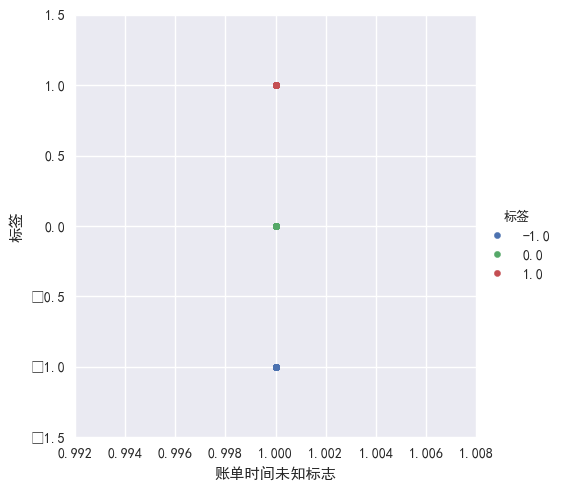

In [150]:
sns.FacetGrid(dataset, hue="标签", size=5).map(plt.scatter, "账单时间未知标志", "标签").add_legend()
#xxx=dataset[['标签','放款时间_x','放款时间_y']]
#sns.pairplot(xxx, hue="标签", size=5)

# KS评测:

In [190]:
#t1=trains.columns
#t2=tests.columns
from sklearn import metrics
def ks(y_predicted, y_true):
    label=y_true
    #label = y_true.get_label()
    fpr,tpr,thres = metrics.roc_curve(label,y_predicted,pos_label=1)
    return 'ks',abs(fpr - tpr).max()

# 划分数据集：

In [204]:
#trains=trains.drop(['放款时间'],axis=1) #55596行  
#tests=tests.drop(['放款时间'],axis=1)#测试集:13899行
online_test=tests
#train_xy,offline_test = train_test_split(trains, test_size = 0.25,random_state=36)#41697/13899
#train,val = train_test_split(train_xy, test_size = 0.333,random_state=24)#27811/13886
#train,val = train_test_split(trains, test_size = 0.25,random_state=20)#41697/13899
#train_xy,offline_test = train_test_split(trains, test_size = 0.25,random_state=10)#41697/13899

#2017.02.04  
train,val = train_test_split(trains, test_size = 0.25,random_state=36)#41697/13886
offline_test=val[:]
#train1,val1 = train_test_split(train_xy, test_size = 0.25,random_state=42)#27811/13886

In [205]:
print(train_xy.shape)
print(train.shape)
print(val.shape)


(41697, 1142)
(35784, 1142)
(11929, 1142)


# **模型:**

In [206]:
start_time = time.time()
offline=0
online=0
params={'booster':'gbtree',
    'objective': 'rank:pairwise',
    'eval_metric':'auc',
    'gamma':0.1,
    'min_child_weight':1.1,
    'max_depth':7,
    'lambda':10,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'colsample_bylevel':0.7,
    'eta': 0.01,
    'tree_method':'exact',
    'seed':1000,
    'nthread':12
    }

params1={
'booster':'gbtree',
'objective': 'binary:logistic',
'scale_pos_weight': 1/7.5,
#7183正样本
#55596条总样本
#差不多1:7.7这样子
'gamma':0.2,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
'max_depth':8, # 构建树的深度，越大越容易过拟合
'lambda':3,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
'subsample':0.7, # 随机采样训练样本
#'colsample_bytree':0.7, # 生成树时进行的列采样
'min_child_weight':3, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
'eta': 0.03, # 如同学习率
'seed':1000,
'nthread':12,# cpu 线程数
'eval_metric': 'auc'
}

plst = list(params.items())
num_rounds = 5000 # 迭代次数

y = train.标签
X = train.drop(['标签','用户标识'],axis=1)
#X=train[feature_list]

val_y = val.标签
val_X = val.drop(['标签','用户标识'],axis=1)
#val_X = val[feature_list]

offline_test_X=offline_test.drop(['标签','用户标识'],axis=1)
online_test_X=online_test.drop(['标签','用户标识'],axis=1)
#offline_test_X=offline_test[feature_list]
#online_test_X=online_test[feature_list]

xgb_train = xgb.DMatrix(X, label=y)
xgb_val = xgb.DMatrix(val_X,label=val_y)

xgb_offline_test = xgb.DMatrix(offline_test_X)
xgb_online_test = xgb.DMatrix(online_test_X)

# return 训练和验证的错误率
watchlist = [(xgb_train, 'train'),(xgb_val, 'val')]

print ("跑到这里了xgb.train")
# training model 
# early_stopping_rounds 当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练
model = xgb.train(plst, xgb_train,num_boost_round=7000,evals=watchlist,early_stopping_rounds=500)
print ("跑到这里了save_model")
model.save_model('../model/20170204_D_最好成绩特征训练集删去部分时间未知样本.model') # 用于存储训练出的模型
print ("best best_ntree_limit",model.best_ntree_limit)   #did not save the best,why?
print ("best best_iteration",model.best_iteration) #get it?

print ("跑到这里了model.predict")
preds_offline = model.predict(xgb_offline_test,ntree_limit=model.best_iteration)#
preds_online = model.predict(xgb_online_test,ntree_limit=model.best_iteration)#
offline=offline_test[['用户标识','标签']]
online=online_test[['用户标识']]

offline['预测']=preds_offline
online['预测']=preds_online

print("线下得分;")
print(ks(offline.预测,offline.标签))

print ("跑到这里了,输出结果")
from sklearn.preprocessing import MinMaxScaler
online.预测 = MinMaxScaler().fit_transform(online.预测)
output=online[['用户标识','预测']].rename(index=str, columns={"用户标识": "userid", "预测": "probability"})
output.to_csv("../output/20170204_D_最好成绩特征训练集删去部分时间未知样本.csv",index=None,encoding='utf-8')

#save feature score and feature information:  feature,score,min,max,n_null,n_gt1w
feature_score = model.get_fscore()
feature_score = sorted(feature_score.items(), key=lambda x:x[1],reverse=True)
fs = []
for (key,value) in feature_score:
    fs.append("{0},{1}\n".format(key,value))
    
with open('../feature_score/20170204_D_最好成绩特征训练集删去部分时间未知样本.csv','w') as f:
        f.writelines("feature,score\n")
        f.writelines(fs)
        
cost_time = time.time()-start_time
print ("",'\n',"cost time:",cost_time,"(s)")
print ("跑到这里了,结束！")
# CV训练
#xgb.cv(xgb_config, dtrain, num_boost_round=10, nfold=5, maximize=False, verbose_eval=True)

跑到这里了xgb.train
[0]	train-auc:0.788614	val-auc:0.75592
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 500 rounds.
[1]	train-auc:0.800895	val-auc:0.766921
[2]	train-auc:0.806865	val-auc:0.767971
[3]	train-auc:0.809088	val-auc:0.769902
[4]	train-auc:0.809741	val-auc:0.770718
[5]	train-auc:0.810824	val-auc:0.77257
[6]	train-auc:0.812154	val-auc:0.773315
[7]	train-auc:0.812474	val-auc:0.774518
[8]	train-auc:0.812495	val-auc:0.774897
[9]	train-auc:0.813429	val-auc:0.77449
[10]	train-auc:0.814218	val-auc:0.774453
[11]	train-auc:0.81609	val-auc:0.774416
[12]	train-auc:0.81639	val-auc:0.774447
[13]	train-auc:0.818078	val-auc:0.776148
[14]	train-auc:0.818446	val-auc:0.776147
[15]	train-auc:0.818675	val-auc:0.775749
[16]	train-auc:0.818768	val-auc:0.775837
[17]	train-auc:0.818932	val-auc:0.775448
[18]	train-auc:0.819061	val-auc:0.775484
[19]	train-auc:0.819598	val-auc:0.775456
[20]	train-auc:0.819971	val-auc:0.775059

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda2\envs\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

线下得分;
('ks', 0.46809309123729737)
跑到这里了,输出结果


E:\Anaconda2\envs\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


 
 cost time: 683.0586452484131 (s)
跑到这里了,结束！


In [137]:
p1= pd.read_csv("../output/20170119_D_线下0.48901_线上0.43267.csv",encoding="gb2312") # 注意自己数据路径
p2= pd.read_csv("../output/20170204_A_最好成绩复现.csv",encoding="gb2312") # 注意自己数据路径
p=p1[['userid']]
p['probability']=p1['probability']-p2['probability']

,userid,probability
0,55597,0.0
1,55598,0.0
2,55599,0.0
3,55600,0.0
4,55601,0.0
5,55602,0.0
6,55603,0.0
7,55604,0.0
8,55605,0.0
9,55606,0.0


In [37]:
p1= pd.read_csv("../output/20170119_D_线下0.48901_线上0.43267.csv",encoding="gb2312") # 注意自己数据路径
p2=pd.read_csv("../output/20170129_A.csv",encoding="gb2312") # 注意自己数据路径
p3=pd.read_csv("../output/20170203_A_ 线下0.490839.csv",encoding="gb2312") # 注意自己数据路径
p=p1[['userid']]
p['probability']=0.5*p1['probability']+0.25*p2['probability']+0.25*p3['probability']
p.to_csv("../output/20170203_加权融合.csv",index=None,encoding='utf-8')

In [7]:
#2017.2.7 几个版本融合一下
p1= pd.read_csv("../output/20170119_D_线下0.48901_线上0.43267.csv",encoding="gb2312") # 注意自己数据路径
p2=pd.read_csv("../output/20170204_C_删除部分时间未知样本_第2_0.43020.csv",encoding="gb2312") # 注意自己数据路径
p3=pd.read_csv("../output/20170204_D_最好成绩特征训练集删去部分时间未知样本_第3_0.4298.csv",encoding="gb2312") # 注意自己数据路径
p=p1[['userid']]
p['probability']=0.7*p1['probability']+0.3*p2['probability']
p.to_csv("../output/20170207_加权融合_D.csv",index=None,encoding='utf-8')